In [12]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

nba_players_game_stats.csv
nba_games_all.csv
nba_players_all.csv
nba_betting_money_line.csv
nba_betting_totals.csv
nba_betting_spread.csv
nba_teams_all.csv


In [2]:
bets = pd.read_csv("input/nba-historical-stats-and-betting-data/nba_betting_money_line.csv")
bets.head()

,game_id,book_name,book_id,team_id,a_team_id,price1,price2
0,41100314,Pinnacle Sports,238,1610612759,1610612760,165.0,-183.0
1,41100314,5Dimes,19,1610612759,1610612760,165.0,-175.0
2,41100314,Bookmaker,93,1610612759,1610612760,160.0,-190.0
3,41100314,BetOnline,1096,1610612759,1610612760,165.0,-190.0
4,41100314,Bovada,999996,1610612759,1610612760,155.0,-175.0


In [3]:
games = pd.read_csv("input/nba-historical-stats-and-betting-data/nba_games_all.csv")
games.head()

,game_id,game_date,matchup,team_id,is_home,wl,w,l,w_pct,min,...,ast,stl,blk,tov,pf,pts,a_team_id,season_year,season_type,season
0,20800741,2009-02-06,SAC vs. UTA,1610612762,f,W,29.0,22.0,0.569,240,...,19.0,5.0,4.0,18.0,26.0,111,1610612758,2008,Regular Season,2008-09
1,20800701,2009-01-31,POR vs. UTA,1610612762,f,L,26.0,22.0,0.542,240,...,17.0,6.0,0.0,15.0,22.0,108,1610612757,2008,Regular Season,2008-09
2,20800584,2009-01-16,MEM vs. UTA,1610612762,f,W,24.0,16.0,0.600,240,...,23.0,9.0,3.0,15.0,22.0,101,1610612763,2008,Regular Season,2008-09
3,20800558,2009-01-12,IND @ UTA,1610612762,t,W,23.0,15.0,0.605,240,...,24.0,10.0,6.0,8.0,20.0,120,1610612754,2008,Regular Season,2008-09
4,20800440,2008-12-27,HOU vs. UTA,1610612762,f,L,18.0,14.0,0.563,290,...,35.0,13.0,7.0,9.0,27.0,115,1610612745,2008,Regular Season,2008-09


In [4]:
# Remove useless columns
bets = bets.loc[bets["book_name"] == "Bovada"]
bets = bets.drop(["book_name", "book_id"], axis=1)

In [5]:
# Merge game stats
bets = bets.merge(games[["game_id", "team_id", "a_team_id", "is_home", "wl", "season_year"]], on=["game_id", "team_id", "a_team_id"])

In [6]:
# Convert American Odds to Decimal odds
def conv_odds(row):
    absrow = abs(row)
    if row >= 0:
        odds = (absrow / 100) + 1
    else:
        odds = (100 / absrow) + 1
    return odds
bets["price1"] = bets["price1"].apply(conv_odds)
bets["price2"] = bets["price2"].apply(conv_odds)

In [7]:
# Convert wl to 0 or 1
def conv_wl(row):
    if row == "W":
        return 1
    elif row == "L":
        return 0
bets["wl"] = bets["wl"].apply(conv_wl)

In [8]:
# Where predictions are being generated, right now only random numbers
bets["pred"] = np.random.randint(0, 2, bets.shape[0])

In [9]:
# Find the profit with the given prediction model
def get_profit(row):
    profit = 0
    if row["wl"] == row["pred"]:
        if row["wl"] == 0:
            profit = row["price2"] - 1
        elif row["wl"] == 1:
            profit = row["price1"] - 1
    else:
        profit = -1
    return profit
bets["profit"] = bets.apply(get_profit, axis=1)
bets["profit"].sum()

-439.94600353047866

In [10]:
year_index = []
year_profit = []
for y in bets["season_year"].unique():
    year_bets = bets.loc[bets["season_year"] == y]
    year_index.append(y)
    year_profit.append(year_bets["profit"].sum())
yearly_profit = pd.Series(data=year_profit, index=year_index)
yearly_profit.sort_index()
yearly_profit

2011    -29.180003
2012    -52.939479
2006    -37.058186
2010    -52.719728
2007    -83.241220
2013      7.028338
2008    -34.231791
2014      6.681087
2015      6.640920
2009   -109.814038
2016     17.631773
2017    -78.743678
dtype: float64

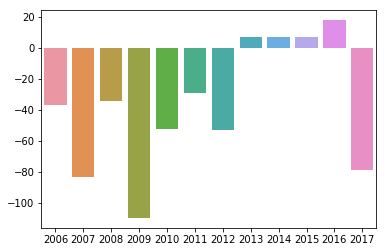

In [11]:
sns.barplot(yearly_profit.index, yearly_profit)